In [7]:
import torch
import torch.nn as nn
import geopandas as gpd
from shapely.geometry import mapping
import rasterio
from rasterio.features import geometry_mask
import numpy as np
import torchvision.transforms as T
from PIL import Image
import h5py
import cv2
from skimage.color import rgb2lab, rgb2gray
from skimage.filters import roberts, sobel
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.transform import resize
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt

# Define a transformation to apply to image patches
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

def extract_polygon_patch(polygon, image_data, transform):
    """Extract image patch within a polygon"""
    mask = geometry_mask([mapping(polygon)], transform=transform, invert=True, out_shape=(image_data.shape[1], image_data.shape[2]))
    masked_data = np.zeros_like(image_data[:3])
    for i in range(3):
        masked_data[i] = image_data[i] * mask
    bounds = polygon.bounds
    window = rasterio.windows.from_bounds(*bounds, transform=transform)
    row_off = int(window.row_off)
    col_off = int(window.col_off)
    height = int(window.height)
    width = int(window.width)
    patch = masked_data[:, row_off:row_off + height, col_off:col_off + width]
    patch = np.moveaxis(patch, 0, -1)
    patch = Image.fromarray(patch.astype(np.uint8))
    return patch

def process_shapefile(shapefile_path, tif_file_path, transform):
    """Process shapefile to extract patches, features, and perform clustering"""
    polygons = gpd.read_file(shapefile_path)
    patches_and_labels = []
    with rasterio.open(tif_file_path) as src:
        image_data = src.read()

    for idx, row in polygons.iterrows():
        polygon = row.geometry
        label = row['sp']
        patch = extract_polygon_patch(polygon, image_data, src.transform)

        # Transform the patch and append to the container
        transformed_patch = transform(patch)
        patches_and_labels.append((transformed_patch, label))
        
        # # Display the resized patch
        # resized_patch = transformed_patch.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
        # resized_patch = resized_patch.clamp(0, 1)  # Ensure the values are within [0, 1]
        # plt.imshow(resized_patch.numpy())
        # plt.title(f'Polygon Label: {label}')
        # plt.show()

    return patches_and_labels

def extract_custom_features(img):
    # Color features
    LAB_img = rgb2lab(img)
    A_img = LAB_img[:,:,1]
    A_feat = A_img.mean()
    
    B_img = LAB_img[:,:,2]
    B_feat = B_img.mean()
    
    # Textural features based on the gray image
    gray_img = rgb2gray(img) 
    gray_img = resize(gray_img, (256,256))  # Resize to smaller size
    gray_img = img_as_ubyte(gray_img)
   
    # Entropy
    entropy_img = entropy(gray_img, disk(3))
    entropy_mean = entropy_img.mean()
    entropy_std = entropy_img.std()
    
    roberts_img = roberts(gray_img)
    roberts_mean = roberts_img.mean()

    sobel_img = sobel(gray_img)
    sobel_mean = sobel_img.mean()
    
    # Gabor filters
    kernel1 = cv2.getGaborKernel((9, 9), 3, np.pi/4, np.pi, 0.5, 0, ktype=cv2.CV_32F)    
    gabor1 = (cv2.filter2D(gray_img, cv2.CV_8UC3, kernel1)).mean()
    
    kernel2 = cv2.getGaborKernel((9, 9), 3, np.pi/2, np.pi/4, 0.9, 0, ktype=cv2.CV_32F)    
    gabor2 = (cv2.filter2D(gray_img, cv2.CV_8UC3, kernel2)).mean()

    kernel3 = cv2.getGaborKernel((9, 9), 5, np.pi/2, np.pi/2, 0.1, 0, ktype=cv2.CV_32F)    
    gabor3 = (cv2.filter2D(gray_img, cv2.CV_8UC3, kernel3)).mean()

    custom_features = np.array([A_feat, B_feat, entropy_mean, entropy_std, roberts_mean, 
                                sobel_mean, gabor1, gabor2, gabor3])
    
    return custom_features

def extract_features(patches_and_labels):
    """Extract custom features"""
    features = []
    labels = []
    for patch, label in patches_and_labels:
        patch_np = patch.permute(1, 2, 0).numpy() * 255  # Convert to numpy array and scale back to 0-255
        patch_np = patch_np.astype(np.uint8)
        feature = extract_custom_features(patch_np)
        features.append(feature)
        labels.append(label)
    
    return features, labels

# Example usage
shapefile_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\202404_101_seg_shp_labeled\\DNDF101_clip_seg_labeled.shp'
tif_file_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\DNDF101_clip.tif'

patches_and_labels = process_shapefile(shapefile_path, tif_file_path, transform)

features, labels = extract_features(patches_and_labels)

# Save features and labels to HDF5 file
with h5py.File('h:\\Yehmh\\DNDF\\101_1_focus\\DNDF_202404_101_1_CustomFeatures.h5', 'w') as h5f:
    h5f.create_dataset('dataset_1', data=np.array(features))
    h5f.create_dataset('dataset_2', data=np.array(labels, dtype='S'))


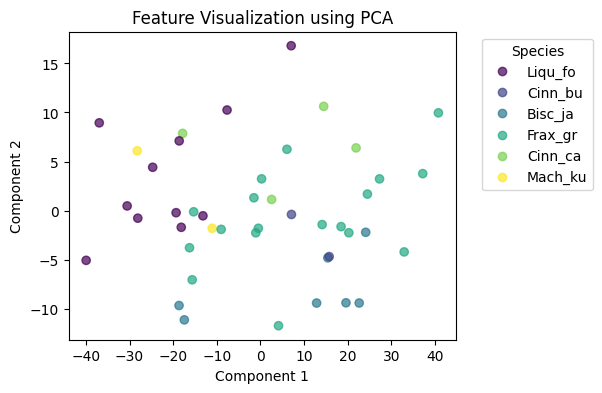

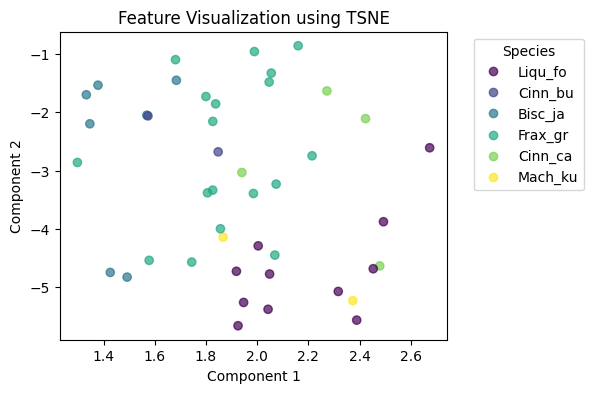

In [15]:
import torch
import torch.nn as nn
import geopandas as gpd
from shapely.geometry import mapping
import rasterio
from rasterio.features import geometry_mask
import numpy as np
import torchvision.transforms as T
from PIL import Image
import h5py
import cv2
from skimage.color import rgb2lab, rgb2gray
from skimage.filters import roberts, sobel
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.transform import resize
from skimage.util import img_as_ubyte
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Define a transformation to apply to image patches
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

def extract_polygon_patch(polygon, image_data, transform):
    """Extract image patch within a polygon"""
    mask = geometry_mask([mapping(polygon)], transform=transform, invert=True, out_shape=(image_data.shape[1], image_data.shape[2]))
    masked_data = np.zeros_like(image_data[:3])
    for i in range(3):
        masked_data[i] = image_data[i] * mask
    bounds = polygon.bounds
    window = rasterio.windows.from_bounds(*bounds, transform=transform)
    row_off = int(window.row_off)
    col_off = int(window.col_off)
    height = int(window.height)
    width = int(window.width)
    patch = masked_data[:, row_off:row_off + height, col_off:col_off + width]
    patch = np.moveaxis(patch, 0, -1)
    patch = Image.fromarray(patch.astype(np.uint8))
    return patch

def process_shapefile(shapefile_path, tif_file_path, transform):
    """Process shapefile to extract patches, features, and perform clustering"""
    polygons = gpd.read_file(shapefile_path)
    patches_and_labels = []
    with rasterio.open(tif_file_path) as src:
        image_data = src.read()

    for idx, row in polygons.iterrows():
        polygon = row.geometry
        label = row['sp']
        patch = extract_polygon_patch(polygon, image_data, src.transform)

        # Transform the patch and append to the container
        transformed_patch = transform(patch)
        patches_and_labels.append((transformed_patch, label))
        
    return patches_and_labels

def extract_custom_features(img):
    # Color features
    LAB_img = rgb2lab(img)
    A_img = LAB_img[:,:,1]
    A_feat = A_img.mean()
    
    B_img = LAB_img[:,:,2]
    B_feat = B_img.mean()
    
    # Textural features based on the gray image
    gray_img = rgb2gray(img) 
    gray_img = resize(gray_img, (256,256))  # Resize to smaller size
    gray_img = img_as_ubyte(gray_img)
   
    # Entropy
    entropy_img = entropy(gray_img, disk(3))
    entropy_mean = entropy_img.mean()
    entropy_std = entropy_img.std()
    
    roberts_img = roberts(gray_img)
    roberts_mean = roberts_img.mean()

    sobel_img = sobel(gray_img)
    sobel_mean = sobel_img.mean()
    
    # Gabor filters
    kernel1 = cv2.getGaborKernel((9, 9), 3, np.pi/4, np.pi, 0.5, 0, ktype=cv2.CV_32F)    
    gabor1 = (cv2.filter2D(gray_img, cv2.CV_8UC3, kernel1)).mean()
    
    kernel2 = cv2.getGaborKernel((9, 9), 3, np.pi/2, np.pi/4, 0.9, 0, ktype=cv2.CV_32F)    
    gabor2 = (cv2.filter2D(gray_img, cv2.CV_8UC3, kernel2)).mean()

    kernel3 = cv2.getGaborKernel((9, 9), 5, np.pi/2, np.pi/2, 0.1, 0, ktype=cv2.CV_32F)    
    gabor3 = (cv2.filter2D(gray_img, cv2.CV_8UC3, kernel3)).mean()

    custom_features = np.array([A_feat, B_feat, entropy_mean, entropy_std, roberts_mean, 
                                sobel_mean, gabor1, gabor2, gabor3])
    
    return custom_features

def extract_features(patches_and_labels):
    """Extract custom features"""
    features = []
    labels = []
    for patch, label in patches_and_labels:
        patch_np = patch.permute(1, 2, 0).numpy() * 255  # Convert to numpy array and scale back to 0-255
        patch_np = patch_np.astype(np.uint8)
        feature = extract_custom_features(patch_np)
        features.append(feature)
        labels.append(label)
    
    return features, labels

def visualize_features(features, labels, method='pca'):
    """Visualize features using PCA or t-SNE"""
    label_to_int = {label: i for i, label in enumerate(set(labels))}
    numerical_labels = [label_to_int[label] for label in labels]

    features = np.array(features)  # Convert features list to numpy array

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2)
    
    reduced_features = reducer.fit_transform(features)
    
    plt.figure(figsize=(5, 4))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=numerical_labels, cmap='viridis', alpha=0.7)
    
    # Create a legend with species names
    handles, _ = scatter.legend_elements()
    legend_labels = [label for label, int_val in label_to_int.items()]
    # plt.legend(handles, legend_labels, title="Species")
    plt.legend(handles, legend_labels, title="Species", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title(f'Feature Visualization using {method.upper()}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Example usage
shapefile_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\202404_101_seg_shp_labeled\\DNDF101_clip_seg_labeled.shp'
tif_file_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\DNDF101_clip.tif'

patches_and_labels = process_shapefile(shapefile_path, tif_file_path, transform)

features, labels = extract_features(patches_and_labels)

# Save features and labels to HDF5 file
with h5py.File('h:\\Yehmh\\DNDF\\101_1_focus\\DNDF_202404_101_1_CustomFeatures.h5', 'w') as h5f:
    h5f.create_dataset('dataset_1', data=np.array(features))
    h5f.create_dataset('dataset_2', data=np.array(labels, dtype='S'))

# Visualize features using PCA
visualize_features(features, labels, method='pca')

# Visualize features using t-SNE
visualize_features(features, labels, method='tsne')


Query Image Label: Bisc_ja
Top 3 images in order are: ['Bisc_ja', 'Bisc_ja', 'Frax_gr']


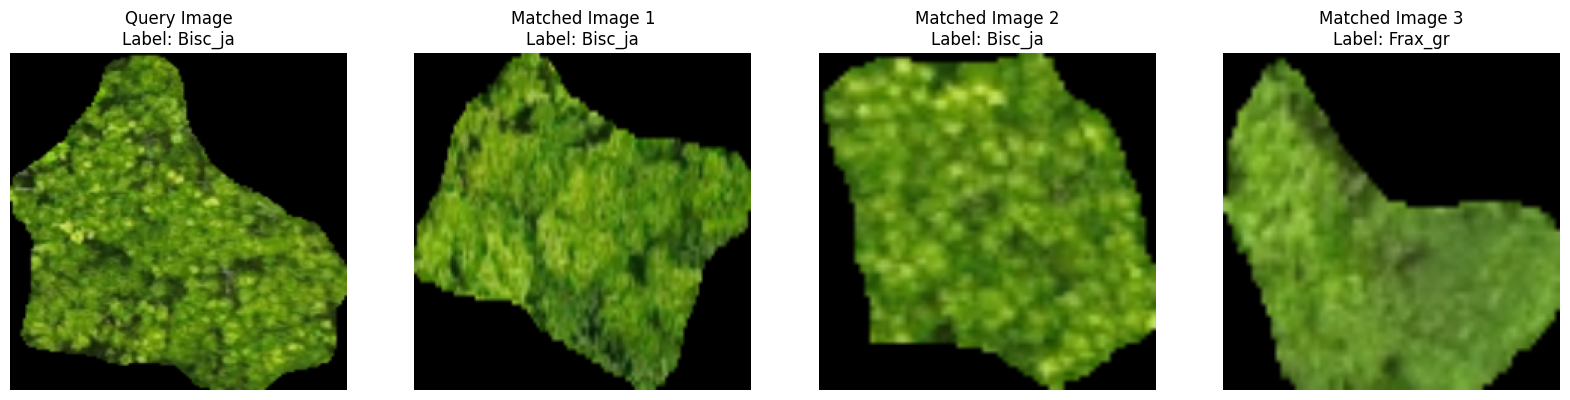

In [10]:
import matplotlib.pyplot as plt
from scipy import spatial
import random
import h5py

# Load features and labels from HDF5 file
h5f = h5py.File('h:\\Yehmh\\DNDF\\101_1_focus\\DNDF_202404_101_1_CustomFeatures.h5', 'r')
feats = h5f['dataset_1'][:]
img_labels = h5f['dataset_2'][:]
h5f.close()

# Select a random query image from the patches
random_index = random.randint(0, len(feats) - 1)
query_features = feats[random_index]
query_patch, query_label = patches_and_labels[random_index]

print(f"Query Image Label: {query_label}")

# Compute the Cosine distance between query features and dataset features
scores = []
for feat in feats:
    score = 1 - spatial.distance.cosine(query_features, feat)
    scores.append(score)
scores = np.array(scores)
rank_ID = np.argsort(scores)[::-1]
rank_score = scores[rank_ID]

# Top 3 matches to the query image (excluding the query image itself)
maxres = 4  # Including the query image
top_indices = rank_ID[1:maxres]

print(f"Top {maxres-1} images in order are:", [img_labels[index].decode('utf-8') for index in top_indices])

# Display the query image and the top matching images
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Display the query image
axs[0].imshow(query_patch.permute(1, 2, 0).numpy())
axs[0].set_title(f"Query Image\nLabel: {query_label}")
axs[0].axis('off')

# Display the top matching images
for i, idx in enumerate(top_indices):
    match_patch, match_label = patches_and_labels[idx]
    axs[i+1].imshow(match_patch.permute(1, 2, 0).numpy())
    axs[i+1].set_title(f"Matched Image {i+1}\nLabel: {match_label}")
    axs[i+1].axis('off')

plt.show()